Analyse über Tech-/Levelvorsprung

In [ ]:
# imports & parquet dateien einlesen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_info = pd.read_parquet("../filtered_data/match_info.parquet")
df_general = pd.read_parquet("../filtered_data/match_player_general.parquet")
df_ts = pd.read_parquet("../filtered_data/match_player_timestamp.parquet")

In [ ]:
#final tech_power/player
last_ts = df_ts.sort_values("timestamp_s").groupby(["match_id", "account_id"]).tail(1)

#team
player_team = df_general[["match_id", "account_id", "team"]].drop_duplicates()
last_ts_team = last_ts.merge(player_team, on=["match_id", "account_id"], how="left")

#avg tech_power / team
team_tech = (
    last_ts_team.groupby(["match_id", "team"])["tech_power"]
    .mean()
    .reset_index()
)

team_tech_wide = team_tech.pivot(
    index="match_id",
    columns="team",
    values="tech_power"
).reset_index()

#tech-diff (Team0 - Team1)
team_tech_wide["tech_diff"] = team_tech_wide["Team0"] - team_tech_wide["Team1"]

merged_tech = team_tech_wide.merge(df_info[["match_id", "winning_team"]], on="match_id")

merged_tech["tech_advantage_winner"] = (
    merged_tech["tech_diff"].apply(lambda x: "Team0" if x > 0 else "Team1")
    == merged_tech["winning_team"]
)

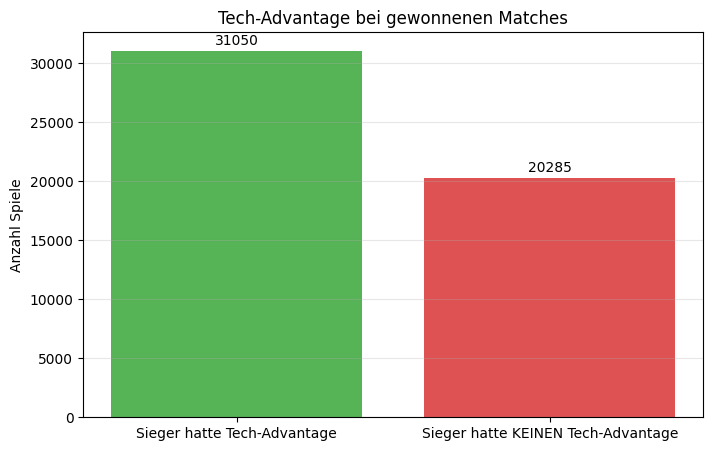

In [ ]:
import matplotlib.pyplot as plt

total_wins = len(merged_tech)
tech_advantage_wins = merged_tech["tech_advantage_winner"].sum()
tech_comeback_wins = total_wins - tech_advantage_wins

labels = ["Sieger hatte Tech-Advantage", "Sieger hatte KEINEN Tech-Advantage"]
values = [tech_advantage_wins, tech_comeback_wins]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=["tab:green", "tab:red"], alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + total_wins * 0.01,
             f"{height}", ha='center', fontsize=10)

plt.title("Tech-Advantage bei gewonnenen Matches")
plt.ylabel("Anzahl Spiele")
plt.grid(axis="y", alpha=0.3)

plt.show()


In [ ]:
player_team = df_general[["match_id", "account_id", "team"]].drop_duplicates()

df_ts_team = df_ts.merge(
    player_team,
    on=["match_id", "account_id"],
    how="left"
)

team_tech_ts = (
    df_ts_team
    .groupby(["match_id", "timestamp_s", "team"])["tech_power"]
    .mean()
    .reset_index()
)

team_tech_ts_wide = team_tech_ts.pivot(
    index=["match_id", "timestamp_s"],
    columns="team",
    values="tech_power"
).reset_index()

team_tech_ts_wide["tech_diff"] = team_tech_ts_wide["Team0"] - team_tech_ts_wide["Team1"]

tech_ts = team_tech_ts_wide.merge(
    df_info[["match_id", "winning_team"]],
    on="match_id",
    how="left"
)

tech_ts["leading_team"] = tech_ts["tech_diff"].apply(
    lambda x: "Team0" if x > 0 else "Team1"
)

tech_ts["lead_correct"] = tech_ts["leading_team"] == tech_ts["winning_team"]

total_matches = tech_ts["match_id"].nunique()

tech_summary_by_time = (
    tech_ts.groupby("timestamp_s")
    .agg(
        avg_tech_diff=("tech_diff", "mean"),
        avg_abs_tech_diff=("tech_diff", lambda s: s.abs().mean()),
        lead_accuracy=("lead_correct", "mean"),
        matchcount=("match_id", "nunique")
    )
    .reset_index()
)

tech_summary_by_time["match_pct"] = tech_summary_by_time["matchcount"] / total_matches * 100

print(tech_summary_by_time.head())
print(tech_summary_by_time.to_string(index=False))


   timestamp_s  avg_tech_diff  avg_abs_tech_diff  lead_accuracy  matchcount  \
0          180      -0.019236           3.379634       0.500010       51335   
1          360      -0.131038           5.749128       0.517133       51335   
2          540      -0.197190           7.196703       0.520586       51321   
3          720      -0.173514           8.974785       0.536818       51306   
4          900      -0.180824          10.123096       0.542989       51246   

    match_pct  
0  100.000000  
1  100.000000  
2   99.972728  
3   99.943508  
4   99.826629  
 timestamp_s  avg_tech_diff  avg_abs_tech_diff  lead_accuracy  matchcount  match_pct
         180      -0.019236           3.379634       0.500010       51335 100.000000
         360      -0.131038           5.749128       0.517133       51335 100.000000
         540      -0.197190           7.196703       0.520586       51321  99.972728
         720      -0.173514           8.974785       0.536818       51306  99.943508
    

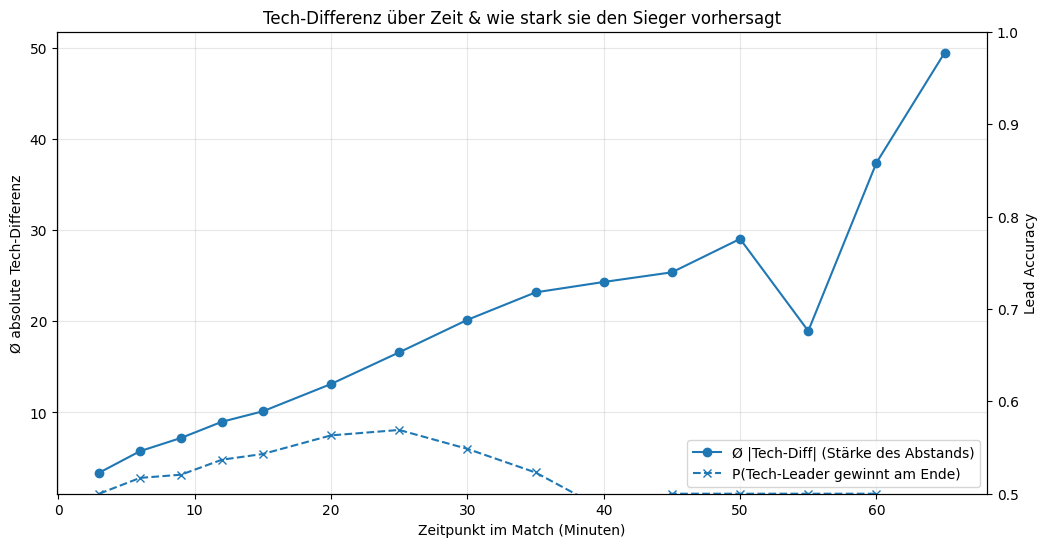

In [ ]:
tech_summary_by_time["timestamp_min"] = tech_summary_by_time["timestamp_s"] / 60

plt.figure(figsize=(12, 6))

ax1 = plt.gca()

ax1.plot(
    tech_summary_by_time["timestamp_min"],
    tech_summary_by_time["avg_abs_tech_diff"],
    marker="o",
    label="Ø |Tech-Diff| (Stärke des Abstands)"
)
ax1.set_xlabel("Zeitpunkt im Match (Minuten)")
ax1.set_ylabel("Ø absolute Tech-Differenz")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(
    tech_summary_by_time["timestamp_min"],
    tech_summary_by_time["lead_accuracy"],
    marker="x",
    linestyle="--",
    label="P(Tech-Leader gewinnt am Ende)"
)
ax2.set_ylabel("Lead Accuracy")
ax2.set_ylim(0.5, 1.0)

plt.title("Tech-Differenz über Zeit & wie stark sie den Sieger vorhersagt")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.show()
